In [41]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser
import glob
import tarfile
import tempfile
import os
import os.path
import PyPDF2
import re
import shutil
from astropy.io import fits
from astropy.time import Time

from astroquery.simbad import Simbad
plt.rcParams["figure.figsize"] = (10,6)
from matplotlib import style
plt.style.use('ggplot')

In [68]:
flattemplate = "/nfs/archive/engineering/elp/nres02/201710??/raw/elp*w00*.fz"
inputfiles = glob.glob (flattemplate)

In [59]:
def getFluxInFlat (inputfilename):
    
    
    hdu = fits.open (inputfilename)[1]
    objects = hdu.header['OBJECTS']
    dateobs = Time(hdu.header['DATE-OBS'], format='isot', scale='utc')
    data = hdu.data
    hdu.close()    
    background = data[3825:3925,100:400]
    background = np.mean ( background[np.abs (background - np.median(background) < 50)])
        
    arcflat = data[1865:1885 , 2200:2250] - background
    objflat = data[1888:1908 , 2200:2250] - background
    arcflat = np.sum (arcflat)
    objflat = np.sum (objflat)
      
    #print ("%s %s %s %s" % (inputfilename, dateobs, arcflat, objflat))
    return dateobs,arcflat,objflat
    
    

In [58]:
dateobs = []
arcflux= []
objflux = []

for infile in inputfiles:
    (do, af, of) =  getFluxInFlat (infile)
    dateobs.append (do.datetime)
    arcflux.append (af)
    objflux.append (of)


dateobs = np.asarray(dateobs)
arcflux = np.asarray(arcflux)
objflux = np.asarray(objflux)
print dateobs, arcflux, objflux

[datetime.datetime(2017, 10, 2, 20, 2, 5, 792000)
 datetime.datetime(2017, 10, 2, 20, 8, 0, 199000)
 datetime.datetime(2017, 10, 2, 20, 13, 55, 624000)
 datetime.datetime(2017, 10, 2, 20, 19, 49, 849000)
 datetime.datetime(2017, 10, 2, 20, 25, 44, 415000)
 datetime.datetime(2017, 10, 2, 20, 31, 46, 90000)
 datetime.datetime(2017, 10, 2, 20, 37, 42, 42000)
 datetime.datetime(2017, 10, 2, 20, 43, 37, 39000)
 datetime.datetime(2017, 10, 2, 20, 49, 31, 880000)
 datetime.datetime(2017, 10, 2, 20, 55, 26, 108000)
 datetime.datetime(2017, 10, 5, 17, 28, 50, 175000)
 datetime.datetime(2017, 10, 5, 17, 34, 46, 936000)
 datetime.datetime(2017, 10, 5, 17, 40, 43, 99000)
 datetime.datetime(2017, 10, 5, 17, 46, 38, 948000)
 datetime.datetime(2017, 10, 5, 17, 52, 34, 294000)
 datetime.datetime(2017, 10, 5, 17, 58, 29, 276000)
 datetime.datetime(2017, 10, 6, 17, 28, 51, 166000)
 datetime.datetime(2017, 10, 6, 17, 34, 46, 999000)
 datetime.datetime(2017, 10, 6, 17, 40, 42, 98000)
 datetime.datetime(20

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


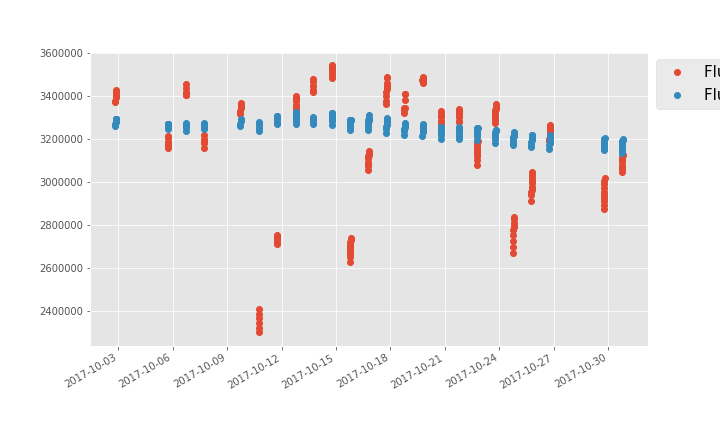

<IPython.core.display.Javascript object>


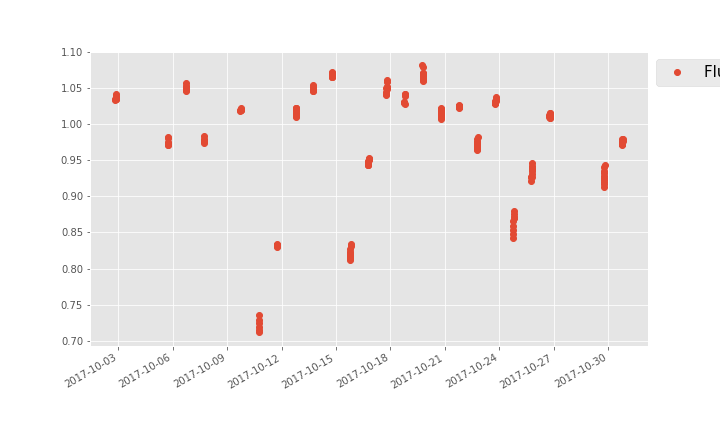

In [75]:
%matplotlib  

plt.plot (dateobs, objflux, "o", label="Flux in arc trace")
plt.plot (dateobs, arcflux, "o", label="Flux in obj trace")

lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,  fontsize=15)
plt.gcf().autofmt_xdate()
plt.show()
plt.savefig ("nres_lampstability.png", box_extra_artists=(lgd,), bbox_inches="tight")


plt.figure()
plt.plot (dateobs, objflux / arcflux , "o", label="Flux ratio obj / arc trace")
lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,  fontsize=15)
plt.gcf().autofmt_xdate()
plt.show()
plt.savefig ("nres_lampstability_ratio.png", box_extra_artists=(lgd,), bbox_inches="tight")
